# Loan Prediction 05 - Training and Validation of Models with MissForest Imputed Dataset

In [15]:
import math
import sys
sys.path.append('utils')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from joblib import dump, load

plt.style.use('seaborn')

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier

import metrics_utils 
import model_utils

In [16]:
df_import = pd.read_csv('dataset/train_rf_imputed.csv')
df_import

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status,Base_Loan_Installment,Remaining_Income
0,1.0,0.0,0.0,0.0,0.0,5849.0,0.0,145.7,360.0,1.0,2.0,1,404.722222,0.930805
1,1.0,1.0,1.0,0.0,0.0,4583.0,1508.0,128.0,360.0,1.0,0.0,0,355.555556,0.941626
2,1.0,1.0,0.0,0.0,1.0,3000.0,0.0,66.0,360.0,1.0,2.0,1,183.333333,0.938889
3,1.0,1.0,0.0,1.0,0.0,2583.0,2358.0,120.0,360.0,1.0,2.0,1,333.333333,0.932537
4,1.0,0.0,0.0,0.0,0.0,6000.0,0.0,141.0,360.0,1.0,2.0,1,391.666667,0.934722
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
577,0.0,0.0,0.0,0.0,0.0,2900.0,0.0,71.0,360.0,1.0,0.0,1,197.222222,0.931992
578,1.0,1.0,3.0,0.0,0.0,4106.0,0.0,40.0,180.0,1.0,0.0,1,222.222222,0.945879
579,1.0,1.0,1.0,0.0,0.0,8072.0,240.0,253.0,360.0,1.0,2.0,1,702.777778,0.915450
580,1.0,1.0,2.0,0.0,0.0,7583.0,0.0,187.0,360.0,1.0,2.0,1,519.444444,0.931499


In [17]:
columns_x = df_import.drop(columns=['Loan_Status']).columns
column_y = ['Loan_Status']

X_train, X_validation, y_train, y_validation = train_test_split(
    df_import[columns_x], df_import[column_y],  test_size=0.20, random_state=42)

In [18]:
scaler = MinMaxScaler()
scaler.fit(df_import[columns_x])

dump(scaler, 'saves/minmax_scaler_miss_forest_imputation.bin', compress=True)
X_train_norm = pd.DataFrame(data=scaler.transform(X_train),columns=X_train.columns)
X_validation_norm = pd.DataFrame(data=scaler.transform(X_validation),columns=X_train.columns)

In [19]:
X_train_norm.describe()
print(X_train_norm.shape)

(465, 13)


In [20]:
X_validation_norm.describe()
print(X_validation_norm.shape)

(117, 13)


### Logistic Regression Classifier

In [21]:
logistic_regression_params = {
    'C' : [1,10,100,1000],
    'penalty' : ['l1', 'l2', 'elasticnet', 'none'],
    'solver' : ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
}

best_lr,best_lr_params,best_lr_score = model_utils.find_best_classification_model_with_cross_validation(
    LogisticRegression(random_state=0, class_weight = 'balanced'),
    logistic_regression_params,
    X_train_norm.values,
    y_train.values.ravel(),
    metric = 'f1')

Fitting 10 folds for each of 80 candidates, totalling 800 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.8s


--- Ellapsed time: 3.3938117027282715 seconds ---
Best params:  {'C': 1, 'penalty': 'l1', 'solver': 'saga'}
Best score (f1) 0.8441261473684486


[Parallel(n_jobs=-1)]: Done 800 out of 800 | elapsed:    3.4s finished


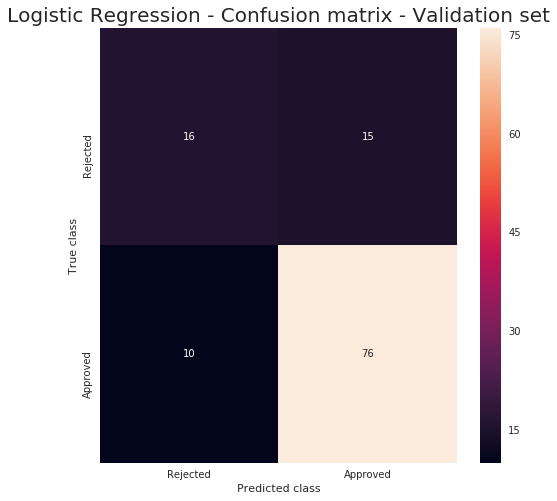

              precision    recall  f1-score   support

    Rejected       0.62      0.52      0.56        31
    Approved       0.84      0.88      0.86        86

    accuracy                           0.79       117
   macro avg       0.73      0.70      0.71       117
weighted avg       0.78      0.79      0.78       117

No Skill: ROC AUC=0.500
Logistic Regression : ROC AUC=0.682


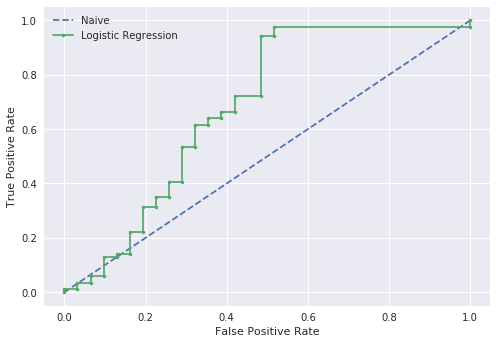

['saves/logistic_regression_miss_forest_imputation.bin']

In [22]:
df_result = model_utils.predict(best_lr,X_validation_norm,y_validation);
metrics_utils.evalute_model_performance(best_lr, 'Logistic Regression',X_validation_norm,y_validation,df_result)
dump(best_lr, 'saves/logistic_regression_miss_forest_imputation.bin', compress=True)

## Ridge Regression

In [23]:
ridge_regression_params = {
    'alpha' : [1,10,100,1000],
    'solver' : ['auto', 'svd', 'lsqr', 'sag', 'cholesky','saga','sparse_cg']
}

best_ridge,best_ridge_params,best_ridge_score = model_utils.find_best_classification_model_with_cross_validation(
    RidgeClassifier(random_state=0, class_weight = 'balanced'),
    ridge_regression_params,
    X_train_norm.values,
    y_train.values.ravel(),
    metric = 'f1')

Fitting 10 folds for each of 28 candidates, totalling 280 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 280 out of 280 | elapsed:    0.4s finished


--- Ellapsed time: 0.4338815212249756 seconds ---
Best params:  {'alpha': 1, 'solver': 'auto'}
Best score (f1) 0.8492553655525568


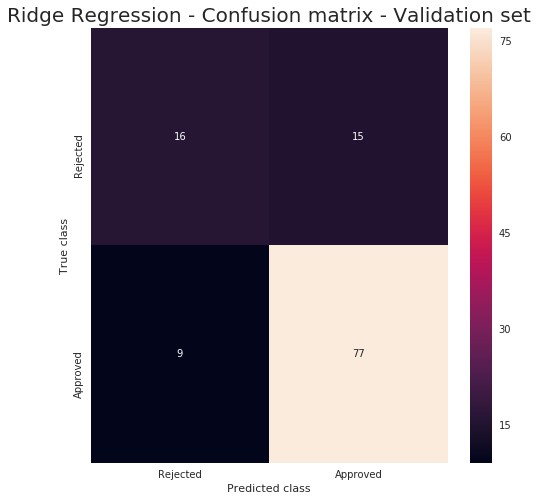

              precision    recall  f1-score   support

    Rejected       0.64      0.52      0.57        31
    Approved       0.84      0.90      0.87        86

    accuracy                           0.79       117
   macro avg       0.74      0.71      0.72       117
weighted avg       0.78      0.79      0.79       117

Could not print ROC AUC curve.


['saves/ridge_regression_miss_forest_imputation.bin']

In [24]:
df_result = model_utils.predict(best_ridge,X_validation_norm,y_validation);
metrics_utils.evalute_model_performance(best_ridge, 'Ridge Regression',X_validation_norm,y_validation,df_result)
dump(best_ridge, 'saves/ridge_regression_miss_forest_imputation.bin', compress=True)

### Random Forest Classifier

In [25]:
random_forest_params = {
    'n_estimators' : [50,100,150,200],
    'min_samples_split': [2,3,4,5],
    'max_depth':[5,8,10,13,15],
    'criterion':['gini','entropy'],
    'oob_score':[True]
}

best_random_forest,best_random_forest_params,best_random_forest_score = model_utils.find_best_classification_model_with_cross_validation(
    RandomForestClassifier(random_state=0, class_weight = 'balanced'),
    random_forest_params,
    X_train_norm.values,
    y_train.values.ravel(),
    metric = 'f1')

Fitting 10 folds for each of 160 candidates, totalling 1600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   11.1s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   25.7s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:   47.1s
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 1600 out of 1600 | elapsed:  1.7min finished


--- Ellapsed time: 102.17863059043884 seconds ---
Best params:  {'criterion': 'entropy', 'max_depth': 5, 'min_samples_split': 4, 'n_estimators': 100, 'oob_score': True}
Best score (f1) 0.8784016760335938


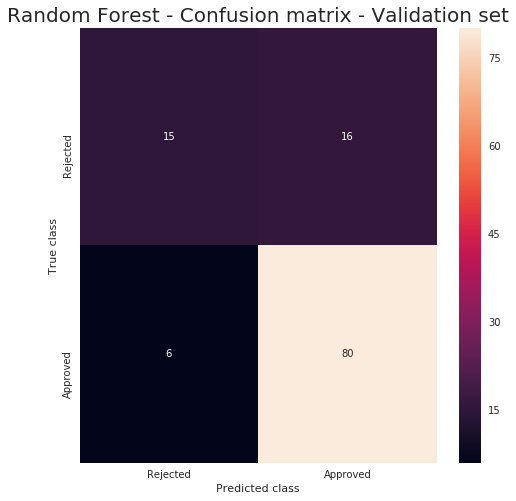

              precision    recall  f1-score   support

    Rejected       0.71      0.48      0.58        31
    Approved       0.83      0.93      0.88        86

    accuracy                           0.81       117
   macro avg       0.77      0.71      0.73       117
weighted avg       0.80      0.81      0.80       117

No Skill: ROC AUC=0.500
Random Forest : ROC AUC=0.767


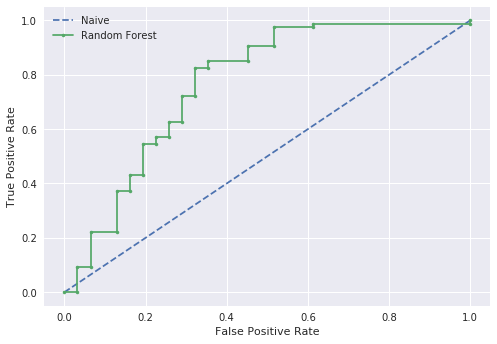

['saves/random_forest_miss_forest_imputation.bin']

In [26]:
df_result = model_utils.predict(best_random_forest,X_validation_norm,y_validation)
metrics_utils.evalute_model_performance(model = best_random_forest, model_name = 'Random Forest', X = X_validation_norm, y = y_validation, df_result = df_result)
dump(best_random_forest, 'saves/random_forest_miss_forest_imputation.bin', compress=True)

### Gradient Boosting

In [27]:
gboost_params = {
    'loss':['deviance', 'exponential'],
    'learning_rate':[0.01,0.1],
    'n_estimators' : [50,100,150],
    'min_samples_split': [2,3,4,5],
    'max_depth':[2,3,5,8]
}

best_gboost,best_gboost_params,best_gboost_score = model_utils.find_best_classification_model_with_cross_validation(
    GradientBoostingClassifier(random_state=0),
    gboost_params,
    X_train_norm.values,
    y_train.values.ravel(),
    metric = 'f1')

Fitting 10 folds for each of 192 candidates, totalling 1920 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 352 tasks      | elapsed:   10.5s
[Parallel(n_jobs=-1)]: Done 642 tasks      | elapsed:   23.1s
[Parallel(n_jobs=-1)]: Done 992 tasks      | elapsed:   41.5s
[Parallel(n_jobs=-1)]: Done 1442 tasks      | elapsed:   59.9s


--- Ellapsed time: 81.53267455101013 seconds ---
Best params:  {'learning_rate': 0.01, 'loss': 'exponential', 'max_depth': 5, 'min_samples_split': 2, 'n_estimators': 50}
Best score (f1) 0.8857871611987888


[Parallel(n_jobs=-1)]: Done 1920 out of 1920 | elapsed:  1.4min finished


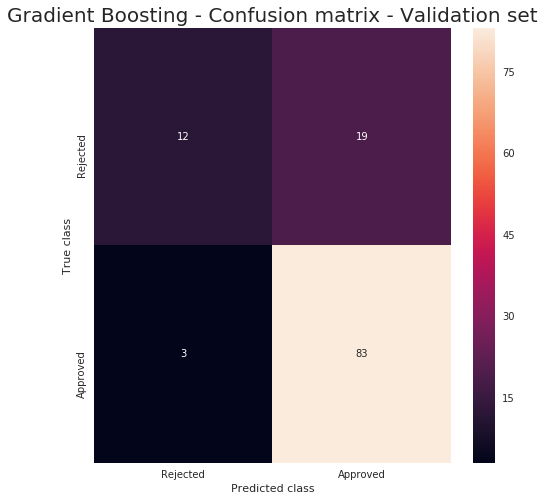

              precision    recall  f1-score   support

    Rejected       0.80      0.39      0.52        31
    Approved       0.81      0.97      0.88        86

    accuracy                           0.81       117
   macro avg       0.81      0.68      0.70       117
weighted avg       0.81      0.81      0.79       117

No Skill: ROC AUC=0.500
Gradient Boosting : ROC AUC=0.697


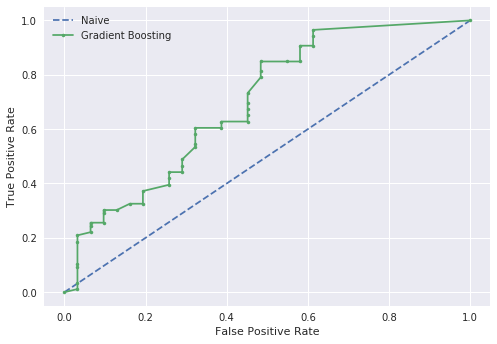

['saves/gradient_boosting_miss_forest_imputation.bin']

In [28]:
df_result = model_utils.predict(best_gboost,X_validation_norm,y_validation)
metrics_utils.evalute_model_performance(model = best_gboost, model_name = 'Gradient Boosting', X = X_validation_norm, y = y_validation, df_result = df_result)
dump(best_gboost, 'saves/gradient_boosting_miss_forest_imputation.bin', compress=True)

### Extreme Gradient Boosting

In [29]:
xgb_params = {'objective':['binary:logistic'],
              'learning_rate': [0.1,0.3,0.5],
              'gamma':[0,1],
              'max_depth': [3,4,6,10],
              'subsample': [0.5, 1],
              'n_estimators': [50,100,150],
              'missing':[-999]}

best_xgb,best_gboost_params,best_gboost_score = model_utils.find_best_classification_model_with_cross_validation(
    XGBClassifier(seed=0),
    xgb_params,
    X_train_norm.values,
    y_train.values.ravel(),
    metric = 'f1')

Fitting 10 folds for each of 144 candidates, totalling 1440 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 560 tasks      | elapsed:    7.2s


--- Ellapsed time: 16.96017074584961 seconds ---
Best params:  {'gamma': 1, 'learning_rate': 0.1, 'max_depth': 3, 'missing': -999, 'n_estimators': 50, 'objective': 'binary:logistic', 'subsample': 1}
Best score (f1) 0.8814913493464338


[Parallel(n_jobs=-1)]: Done 1440 out of 1440 | elapsed:   16.9s finished


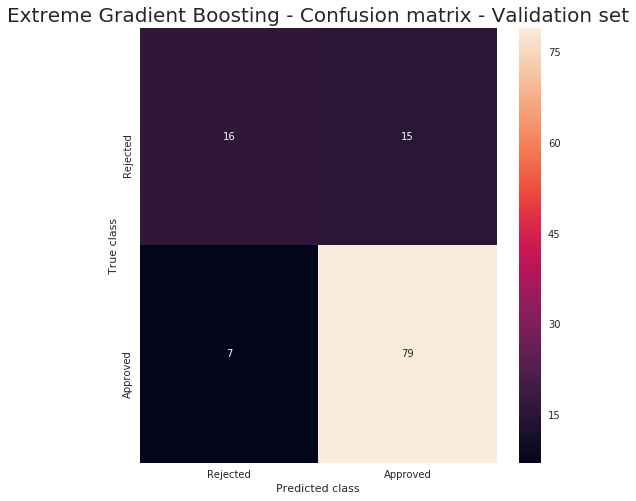

              precision    recall  f1-score   support

    Rejected       0.70      0.52      0.59        31
    Approved       0.84      0.92      0.88        86

    accuracy                           0.81       117
   macro avg       0.77      0.72      0.74       117
weighted avg       0.80      0.81      0.80       117

No Skill: ROC AUC=0.500
Extreme Gradient Boosting : ROC AUC=0.697


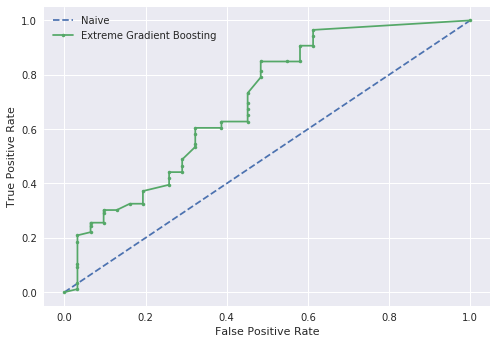

['saves/extreme_gradient_boosting_miss_forest_imputation.bin']

In [31]:
df_result = model_utils.predict(best_xgb,X_validation_norm,y_validation)
metrics_utils.evalute_model_performance(model = best_gboost, model_name = 'Extreme Gradient Boosting', X = X_validation_norm, y = y_validation, df_result = df_result)
dump(best_gboost, 'saves/extreme_gradient_boosting_miss_forest_imputation.bin', compress=True)

## Conclusion

Overall, we can see that all models performed worse when compared to the manual data imputation.
